In [1]:
#
import os
import glob
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torchvision 
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Library Sklearn & Timm
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cek device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:

SUMBER_DATASET_PATH = "C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas" 

# Path output untuk data yang sudah di-split
OUTPUT_SPLIT_PATH = "C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/TA_Klasifikasi_Cacat/dataset_split"

# --- KONFIGURASI MODEL ---
NUM_CLASSES = 7         # 7 kelas cacat
BATCH_SIZE = 32         # Sesuai proposal
NUM_EPOCHS = 100        # Sesuai proposal
LEARNING_RATE = 1e-4    # Sesuai proposal
IMG_SIZE = 224

# Statistik normalisasi ImageNet
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

# Nama model yang akan diuji
MODEL_NAMES = ['mobilenet', 'mobilevit', 'swin']

In [3]:


# Pastikan variabel ini SAMA PERSIS dengan yang ada di Sel 2
DEBUG_PATH = "C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas" 

# 1. Kita cari tahu dulu ada folder apa saja di dalam path itu
folders_ditemukan = glob.glob(os.path.join(DEBUG_PATH, "*"))

print(f"Path yang dicek: {DEBUG_PATH}")
print("="*30)
print(f"Folder/file yang ditemukan di dalamnya ({len(folders_ditemukan)}):")
for f in folders_ditemukan:
    print(f"  -> {f}")

# 2. Kita tes pola pencarian gambar kita
pola_pencarian_gambar = os.path.join(DEBUG_PATH, "*", "*.png")
gambar_ditemukan = glob.glob(pola_pencarian_gambar)

print("="*30)
print(f"Mencoba mencari gambar dengan pola: {pola_pencarian_gambar}")
print(f"Total gambar ditemukan: {len(gambar_ditemukan)}")
if len(gambar_ditemukan) > 0:
    print(f"Contoh gambar pertama: {gambar_ditemukan[0]}")

Path yang dicek: C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas
Folder/file yang ditemukan di dalamnya (7):
  -> C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\finishing roll printing
  -> C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\iron sheet ash
  -> C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\oxide scale of plate system
  -> C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\oxide scale of temperature system
  -> C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\red iron
  -> C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\slag inclusion
  -> C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\surface scratch
Mencoba mencari gambar dengan pola: C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\*\*.png
Total gambar ditemukan: 142
Contoh gambar pertama: C:/Document/TAAAAA CUYYYY/X-SDD-A-New-benchmark_FIX/X-SDD/datas\finishing roll printing\6001

In [4]:
#
def split_dataset(sumber_path, output_path):
    print(f"Membaca data dari: {sumber_path}")
    
    # Kumpulkan semua path gambar (asumsi format .png, ganti jika perlu)
    print("Mencari file .png, .jpg, dan .jpeg...")

    exts = ["*.png", "*.jpg", "*.jpeg"]
    image_paths = []
    for ext in exts:
        pattern = os.path.join(sumber_path, "*", ext)
        image_paths.extend(glob.glob(pattern))

    print(f"Total ditemukan {len(image_paths)} gambar (png/jpg/jpeg)") 
    
    if not image_paths:
        print(f"Error: Tidak ada gambar .png ditemukan di {sumber_path}. Periksa path/format file.")
        return

    # Ambil label (nama folder)
    labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
    print(f"Total gambar ditemukan: {len(image_paths)}")

    # Stratified Split 90% train, 10% test
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
    train_indices, test_indices = next(sss.split(image_paths, labels))
    print(f"Membagi data: {len(train_indices)} latih (90%), {len(test_indices)} uji (10%).")

    
    def copy_files(indices, set_name):
        for idx in indices:
            src_path = image_paths[idx]
            label = labels[idx]
            dest_dir = os.path.join(output_path, set_name, label)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(src_path, dest_dir)

    if os.path.exists(output_path):
        print(f"Folder {output_path} sudah ada. Menghapus folder lama...")
        shutil.rmtree(output_path)
    
    # Salin file
    copy_files(train_indices, "train")
    copy_files(test_indices, "test")
    print(f"Pemisahan data selesai. Data disimpan di: {output_path}")

# --- PENTING! JALANKAN INI HANYA SEKALI ---
print("Memulai pemisahan dataset...")
# split_dataset(SUMBER_DATASET_PATH, OUTPUT_SPLIT_PATH)

Memulai pemisahan dataset...


In [4]:
#
# Definisikan transformasi
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # Augmentasi 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15), 
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_NET_MEAN, IMAGE_NET_STD) # 
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_NET_MEAN, IMAGE_NET_STD) # 
    ]),
}
print("Transformasi data berhasil didefinisikan.")

Transformasi data berhasil didefinisikan.


In [5]:
#
def create_dataloaders(data_dir, batch_size=32):
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    # Dataset 'train' (90%) akan kita pecah lagi
    full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
    
    # Dataset 'test' (10%) pakai transform 'test'
    test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])
    
    # Sesuai proposal: 90% data latih dipecah 80% (latih) dan 20% (validasi) [cite: 385]
    total_train_size = len(full_train_dataset)
    val_size = int(total_train_size * 0.20)
    train_size = total_train_size - val_size
    
    print(f"Total data 90%: {total_train_size} -> Dibagi jadi {train_size} latih & {val_size} validasi.")
    
    # Pecah datanya
    train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(42))
    
    # --- PENTING ---
    # Saat validasi, kita ingin pakai transform 'test' (tanpa augmentasi)
    # Jadi kita 'tweak' dataset validasi-nya
    val_subset.dataset = datasets.ImageFolder(train_dir, transform=data_transforms['test'])
    # Ini trik agar 'val_subset' tetap menunjuk ke indeks yang benar, tapi transform-nya beda

    # Buat DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    class_names = full_train_dataset.classes
    print(f"Kelas terdeteksi: {class_names}")

    return train_loader, val_loader, test_loader, class_names

# --- Eksekusi fungsi untuk memuat data ---
train_loader, val_loader, test_loader, class_names = create_dataloaders(OUTPUT_SPLIT_PATH, BATCH_SIZE)

Total data 90%: 1224 -> Dibagi jadi 980 latih & 244 validasi.
Kelas terdeteksi: ['finishing roll printing', 'iron sheet ash', 'oxide scale of plate system', 'oxide scale of temperature system', 'red iron', 'slag inclusion', 'surface scratch']


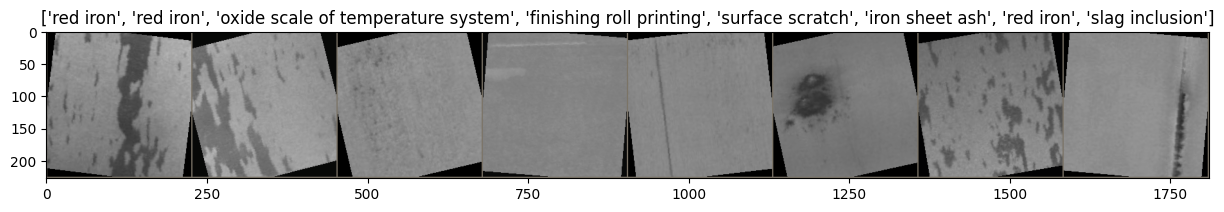

In [6]:
#
# Helper function untuk menampilkan gambar
def imshow(inp, title=None):
    """Menampilkan gambar tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    # De-normalisasi
    mean = np.array(IMAGE_NET_MEAN)
    std = np.array(IMAGE_NET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Ambil satu batch data latih
inputs, classes = next(iter(train_loader))

# Buat grid dari batch
out = torchvision.utils.make_grid(inputs[:8]) 
plt.figure(figsize=(15, 5))
imshow(out, title=[class_names[x] for x in classes[:8]])

In [7]:
def get_model(model_name, num_classes=7):
    model = None
    
    if model_name == 'mobilenet':
        # Sesuai proposal: MobileNet
        model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == 'mobilevit':
        # Buat model MobileViT dari timm
        model = timm.create_model('mobilevit_xs', pretrained=True)
        
        # Cara yang benar untuk mengganti classifier di MobileViT
        # MobileViT menggunakan head.fc sebagai classifier
        if hasattr(model, 'head'):
            if hasattr(model.head, 'fc'):
                # Untuk model dengan head.fc
                num_ftrs = model.head.fc.in_features
                model.head.fc = nn.Linear(num_ftrs, num_classes)
            elif hasattr(model.head, 'in_features'):
                # Untuk model dengan head langsung sebagai Linear
                num_ftrs = model.head.in_features
                model.head = nn.Linear(num_ftrs, num_classes)
            else:
                # Fallback: reset classifier dengan metode timm
                model.reset_classifier(num_classes)
        else:
            # Jika tidak ada head, gunakan metode reset_classifier
            model.reset_classifier(num_classes)
        
    elif model_name == 'swin':
        # Sesuai proposal: Swin Transformer (varian 'tiny')
        model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
        num_ftrs = model.head.in_features
        model.head = nn.Linear(num_ftrs, num_classes) # (in_features, out_features)
        
    else:
        raise ValueError("Nama model tidak dikenal. Pilih 'mobilenet', 'mobilevit', atau 'swin'.")
        
    return model

print("Fungsi 'get_model' v2 (FINAL) berhasil didefinisikan.")

Fungsi 'get_model' v2 (FINAL) berhasil didefinisikan.


In [8]:
#
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    model.to(device)
    
    best_val_acc = 0.0
    best_model_path = f"best_model_{model_name}.pth"
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Memulai pelatihan {model_name} di {device}...")

    for epoch in range(num_epochs):
        start_time = time.time()
        
        # --- Tahap Pelatihan ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # --- Tahap Validasi ---
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        # Simpan history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
        # Perbarui learning rate
        scheduler.step()
        
        end_time = time.time()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Waktu: {end_time - start_time:.2f}s | LR: {scheduler.get_last_lr()[0]:.1e}")
        print(f"  Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"  Val   Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

        # Simpan model terbaik
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> Model terbaik disimpan ke {best_model_path} (Akurasi: {best_val_acc:.4f})")
            
    print(f"Pelatihan selesai. Model terbaik disimpan di {best_model_path}")
    return best_model_path, history

In [9]:

all_histories = {}
all_best_paths = {}

# Model Mobile Net

In [11]:
#
# --- EKSPERIMEN 1: MobileNet ---
print("="*30)
print("Memulai Eksperimen 1: MobileNet")
print("="*30)

model_name_1 = 'mobilenet'
model_1 = get_model(model_name_1, NUM_CLASSES)

# Hiperparameter sesuai proposal
criterion_1 = nn.CrossEntropyLoss() # [cite: 414]
optimizer_1 = optim.AdamW(model_1.parameters(), lr=LEARNING_RATE) # [cite: 427]
scheduler_1 = CosineAnnealingLR(optimizer_1, T_max=NUM_EPOCHS) # [cite: 430]

# Mulai pelatihan
best_path, history = train_model(model_1, model_name_1, 
                                 train_loader, val_loader, 
                                 criterion_1, optimizer_1, scheduler_1, 
                                 num_epochs=NUM_EPOCHS)

all_histories[model_name_1] = history
all_best_paths[model_name_1] = best_path

Memulai Eksperimen 1: MobileNet
Memulai pelatihan mobilenet di cpu...
Epoch 1/100 | Waktu: 142.38s | LR: 1.0e-04
  Train Loss: 1.0027 Acc: 0.7061
  Val   Loss: 0.6875 Acc: 0.7664
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.7664)
Epoch 2/100 | Waktu: 146.49s | LR: 1.0e-04
  Train Loss: 0.2575 Acc: 0.9357
  Val   Loss: 0.1180 Acc: 0.9836
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9836)
Epoch 3/100 | Waktu: 154.85s | LR: 1.0e-04
  Train Loss: 0.1149 Acc: 0.9765
  Val   Loss: 0.0520 Acc: 0.9877
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9877)
Epoch 4/100 | Waktu: 157.07s | LR: 1.0e-04
  Train Loss: 0.0706 Acc: 0.9867
  Val   Loss: 0.0322 Acc: 0.9918
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9918)
Epoch 5/100 | Waktu: 159.47s | LR: 9.9e-05
  Train Loss: 0.0458 Acc: 0.9908
  Val   Loss: 0.0279 Acc: 0.9959
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9959)
Epoch 6/100 | W

# Mobile Vit

In [10]:
#
# --- EKSPERIMEN 2: MobileViT ---
print("="*30)
print("Memulai Eksperimen 2: MobileViT")
print("="*30)

model_name_2 = 'mobilevit'
model_2 = get_model(model_name_2, NUM_CLASSES)

# Hiperparameter
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.AdamW(model_2.parameters(), lr=LEARNING_RATE)
scheduler_2 = CosineAnnealingLR(optimizer_2, T_max=NUM_EPOCHS)

# Mulai pelatihan
best_path, history = train_model(model_2, model_name_2, train_loader, val_loader, criterion_2, optimizer_2, scheduler_2, num_epochs=NUM_EPOCHS)

all_histories[model_name_2] = history
all_best_paths[model_name_2] = best_path

Memulai Eksperimen 2: MobileViT
Memulai pelatihan mobilevit di cpu...
Epoch 1/100 | Waktu: 176.02s | LR: 1.0e-04
  Train Loss: 1.7398 Acc: 0.5867
  Val   Loss: 1.4674 Acc: 0.7131
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.7131)
Epoch 2/100 | Waktu: 184.67s | LR: 1.0e-04
  Train Loss: 1.2369 Acc: 0.8500
  Val   Loss: 0.8859 Acc: 0.9016
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.9016)
Epoch 3/100 | Waktu: 183.12s | LR: 1.0e-04
  Train Loss: 0.7421 Acc: 0.9122
  Val   Loss: 0.5338 Acc: 0.9426
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.9426)
Epoch 4/100 | Waktu: 188.93s | LR: 1.0e-04
  Train Loss: 0.4600 Acc: 0.9490
  Val   Loss: 0.3143 Acc: 0.9631
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.9631)
Epoch 5/100 | Waktu: 191.59s | LR: 9.9e-05
  Train Loss: 0.3209 Acc: 0.9592
  Val   Loss: 0.1994 Acc: 0.9754
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.9754)
Epoch 6/100 | W

KeyboardInterrupt: 

# Swin T

In [11]:
#
# --- EKSPERIMEN 3: Swin Transformer ---
print("="*30)
print("Memulai Eksperimen 3: Swin Transformer")
print("="*30)

model_name_3 = 'swin'
model_3 = get_model(model_name_3, NUM_CLASSES)

# Hiperparameter
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.AdamW(model_3.parameters(), lr=LEARNING_RATE)
scheduler_3 = CosineAnnealingLR(optimizer_3, T_max=NUM_EPOCHS)

# Mulai pelatihan
best_path, history = train_model(model_3, model_name_3, 
train_loader, val_loader, 
criterion_3, optimizer_3, scheduler_3, 
num_epochs=NUM_EPOCHS)

all_histories[model_name_3] = history
all_best_paths[model_name_3] = best_path

Memulai Eksperimen 3: Swin Transformer
Memulai pelatihan swin di cpu...


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

# Grafik Comparison 

In [ ]:
#
plt.figure(figsize=(20, 10))

# Plot Akurasi
plt.subplot(1, 2, 1)
for model_name in MODEL_NAMES:
    plt.plot(all_histories[model_name]['val_acc'], label=f'{model_name} Val Acc')
plt.title('Perbandingan Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
for model_name in MODEL_NAMES:
    plt.plot(all_histories[model_name]['val_loss'], label=f'{model_name} Val Loss')
plt.title('Perbandingan Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("perbandingan_grafik_pelatihan.png")
plt.show()

# Evaluate Model

In [ ]:
#
def evaluate_model(model_name, model_path, test_loader, class_names):
    # Muat model
    model = get_model(model_name, NUM_CLASSES)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    print(f"\nMengevaluasi {model_name} pada data test...")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Hitung Metrik [cite: 445]
    report = classification_report(all_labels, all_preds, 
                                   target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"--- Laporan Klasifikasi untuk {model_name} ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot Confusion Matrix [cite: 445]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    print(f"Confusion matrix disimpan ke confusion_matrix_{model_name}.png")
    
    # Ambil metrik utama
    return {
        'accuracy': report['accuracy'],
        'precision (macro)': report['macro avg']['precision'],
        'recall (macro)': report['macro avg']['recall'],
        'f1-score (macro)': report['macro avg']['f1-score']
    }

In [ ]:
#
all_reports = {}

for model_name in MODEL_NAMES:
    model_path = all_best_paths[model_name]
    report = evaluate_model(model_name, model_path, test_loader, class_names)
    all_reports[model_name] = report

# --- HASIL AKHIR ---
print("\n" + "="*50)
print("     PERBANDINGAN KINERJA MODEL FINAL (DATA TEST)      ")
print("="*50)

# Ubah ke DataFrame Pandas biar rapi
df_report = pd.DataFrame.from_dict(all_reports, orient='index')
print(df_report.to_markdown(floatfmt=".4f"))

# Simpan ke file
df_report.to_csv("perbandingan_model_final.csv")
print("\nPerbandingan final disimpan ke perbandingan_model_final.csv")

# Evaluate Model coba

In [ ]:
#
def evaluate_model(model_name, model_path, test_loader, class_names):
    """
    Fungsi untuk memuat model dan mengevaluasinya pada data uji.
    """
    # 1. Muat arsitektur model
    model = get_model(model_name, NUM_CLASSES)
    
    # 2. Muat bobot (weights) terbaik yang sudah kamu latih
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval() # Set model ke mode evaluasi (penting!)
    
    all_preds = []
    all_labels = []
    
    print(f"\nMengevaluasi {model_name} pada {len(test_loader.dataset)} data uji...")
    
    # Matikan perhitungan gradien untuk hemat memori
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Lakukan prediksi
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Kumpulkan semua prediksi dan label asli
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # 3. Hitung Metrik
    accuracy = accuracy_score(all_labels, all_preds)
    report_dict = classification_report(all_labels, all_preds, 
                                        target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    
    print("="*50)
    print(f"--- HASIL EVALUASI: {model_name} ---")
    print(f"Akurasi Keseluruhan: {accuracy * 100:.2f}%")
    print("="*50)

    print("Laporan Klasifikasi Lengkap:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 5. Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    print(f"\nConfusion matrix disimpan ke confusion_matrix_{model_name}.png")
    
    return report_dict

print("Fungsi 'evaluate_model' siap digunakan.")

Fungsi 'evaluate_model' siap digunakan.


Path model ditemukan: best_model_mobilenet.pth

Mengevaluasi mobilenet pada 136 data uji...
--- HASIL EVALUASI: mobilenet ---
Akurasi Keseluruhan: 97.06%
Laporan Klasifikasi Lengkap:
                                   precision    recall  f1-score   support

          finishing roll printing       0.95      1.00      0.98        20
                   iron sheet ash       0.86      1.00      0.92        12
      oxide scale of plate system       1.00      1.00      1.00         6
oxide scale of temperature system       1.00      1.00      1.00        20
                         red iron       1.00      1.00      1.00        40
                   slag inclusion       0.96      0.96      0.96        24
                  surface scratch       1.00      0.79      0.88        14

                         accuracy                           0.97       136
                        macro avg       0.97      0.96      0.96       136
                     weighted avg       0.97      0.97      0.97 

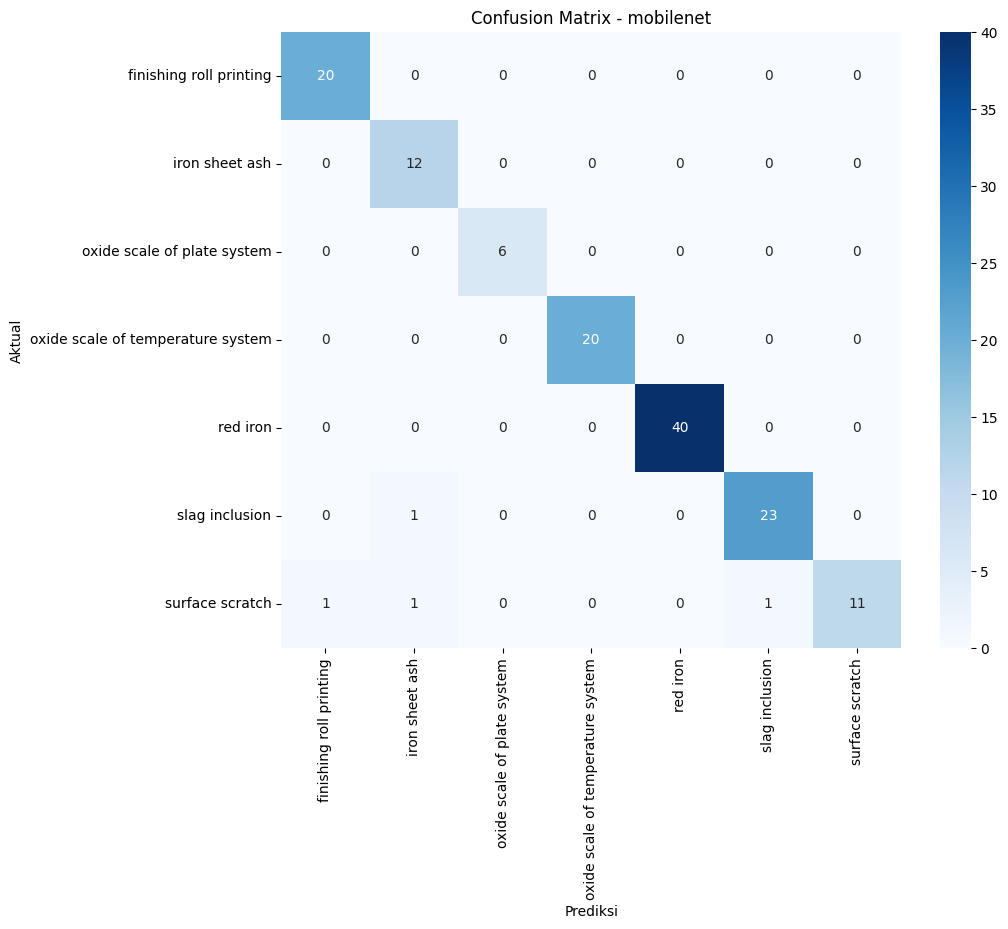

In [ ]:
#
# --- JALANKAN EVALUASI UNTUK MOBILENET ---

MODEL_YANG_DIEVALUASI = 'mobilenet'

# 1. Ambil path model terbaik dari dictionary (jika kamu sudah menjalankan Sel 10)
# Pastikan Sel 10 sudah selesai dan 'all_best_paths' ada isinya
try:
    path_model_terbaik = all_best_paths[MODEL_YANG_DIEVALUASI]
    print(f"Path model ditemukan: {path_model_terbaik}")

    # 2. Panggil fungsi evaluasi
    # (Pastikan 'test_loader' dan 'class_names' sudah ada dari Sel 5)
    laporan = evaluate_model(MODEL_YANG_DIEVALUASI, 
                             path_model_terbaik, 
                             test_loader, 
                             class_names)
    
    # 3. Tampilkan metrik utama
    print("\n--- Ringkasan (Macro Avg) ---")
    macro_avg = laporan['macro avg']
    print(f"Akurasi    : {laporan['accuracy'] * 100:.2f}%")
    print(f"Presisi    : {macro_avg['precision'] * 100:.2f}%")
    print(f"Recall     : {macro_avg['recall'] * 100:.2f}%")
    print(f"F1-Score   : {macro_avg['f1-score'] * 100:.2f}%")

except KeyError:
    print(f"Error: Tidak dapat menemukan path untuk model '{MODEL_YANG_DIEVALUASI}'.")
    print("Pastikan kamu sudah menjalankan sel pelatihan (Sel 10) dan nama modelnya benar.")
except NameError:
    print("Error: 'all_best_paths' tidak ditemukan.")
    print("Pastikan kamu sudah menjalankan Sel 9 (inisialisasi dict) dan Sel 10 (pelatihan).")